Let's start by importing the useful libraries and classes.

In [30]:
import libs
from classes.LP import LabelPropagation
from classes.DATAPREP import Dataprep
from classes.CRF import Crf
from classes.WRAPPER import WrapLabelSpreading
from classes.W2V import Word2Vec
from classes.CROSSVALIDATION import CrossValidation
from classes.INTERPOLATION import Interpolation

Then import data

In [47]:
data = pd.read_csv("/home/sgoutin/Bureau/Projet perso/ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


The Dataprep class has been designed to prepare data for CRF and Label propagation.
Unfortunatly, we are forced to use a sub-sample of the data because we will not be able to create a $n \times n$ matrix with a large value of $n$ as mentionned in the *README* file.

In [48]:
d = Dataprep(data[:20000])

Here we can see that we formulate the problem as an IOB (Inside, Outside, Beginning) tagging problem.

In [49]:
set([w[0] for w in d.tags])

{'B', 'I', 'O'}

## Fitting the models separatly

### F1 score

To measure the quality of all our models, we use the F1 score ignoring the values tagged as outside.

In [50]:
f1_scorer = make_scorer(metrics.flat_f1_score, average='weighted', labels=[w for w in d.tags if w!="O"])

### CRF

CRF training dataset is built

In [51]:
d.dataset_crf()

Now we use GridSearch to tune parameters to find best f1 score for CRF.

In [52]:
tuned_parameters = [{'algorithm': ['lbfgs'], 'c1': [0.1], 'c2': [0.1]}]
GS = GridSearchCV(CRF(), tuned_parameters, f1_scorer, verbose=1)
GS.fit(d.x_crf, d.y_crf)
print(GS.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished


{'algorithm': 'lbfgs', 'c1': 0.1, 'c2': 0.1}


### Label spreading

To construct the graph, tokens are modeled with a vectorization of 5 grams centered by the current token performed by a word embedding model. With word2vec, the 5-grams vector is computed in performing an average of the words vectors weighted with the tf-idf method.

We use a pre-trained word2vec model from google and perform a basic transfert learning.

In [53]:
w2v = Word2VecModel(300, 5, 1, 2)
w2v.pre_trained("/home/sgoutin/Bureau/Projet perso/GoogleNews-vectors-negative300.bin", d.sentences_word)

d.addW2v(w2v)

Label propagation training dataset is built

In [ ]:
d.dataset_lp()

Then we use GridSearch again to tune parameters to find best f1 score for CRF.

* In order to perform a grid search over label spreading as a semi-supervised model, we need to search over the transductive accuracy. That's why we need to provide a wrapper that masks a subset of the data before the fitting step. This is the purpose of the WrapLabelSpreading class.

* In performing GridSearch on Label spreading, I didn't find out how to use our f1 metrics as scorer. Default scorer used by GridSearch for multiclass problem is subset accuracy, which is unsuitable for our problem.

In [55]:
X, y = [w for s in d.X_LP for w in s], [w for s in d.y_LP for w in s]

lp = GridSearchCV(
                WrapLabelSpreading(kernel='knn', supervision_fraction=0.05),
                param_grid={
                    'n_jobs': [-1],
                    'max_iter': [100],
                    'alpha': [0.9],
                    'n_neighbors': [15]})
lp.fit(np.array(X), np.array(y))
print(lp.best_params_)

{'alpha': 0.9, 'max_iter': 100, 'n_jobs': -1, 'n_neighbors': 15}


## Combine Label spreading and CRF

Now that we get our best parameters for each model, we should look for the best mixing coefficient. 

This mean we need to find the best $\alpha \in [0,1]$ such as the interpolation $predCRF \times \alpha + predLP \times (1-\alpha)$ leads to the best f1 score.

In [56]:
param_crf = {"c1":0.1, "c2":0.1}
param_lp = {"alpha":0.9, "n_neighbors":15}

We search the best $\alpha$ by applying a cross-validation for a range of values. A score is returned for each of them.

In [29]:
cv = cross_validation(d, fold=5)
scores = cv.perform_recherche_mixture(param_crf, param_lp)

Now we can plot the f1 score for each value of alpha

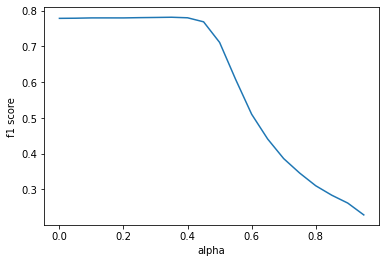

In [46]:
alphas = np.arange(0, 1, 0.05).tolist()

plt.plot(alphas, scores)
plt.ylabel('f1 score')
plt.xlabel('alpha')
plt.show()

Let's take a look at the first values of alpha (before the collapse of alpha).

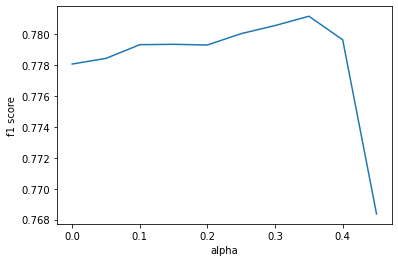

In [44]:
plt.plot(alphas[:10], scores[:10])
plt.ylabel('f1 score')
plt.xlabel('alpha')
plt.show()

$\alpha$ equal to 0 means we only take in account the CRF predictions.
The f1 score increases slowly until it reaches 0.8 for $\alpha$ = 0.35 before collapsing.
The best $\alpha$ is 0.4 but the score is only 0.2% higher than that for $\alpha$ = 0 which does not seems to be significant.

These bad results might be caused by :
* A bad parameters tuning of the label propagation model due to the use of the subset accuracy metric.
* The use of a subsamble. We couldn't take advantage of the large quantity of unlabeled data.